# Quick Start

The notebook contains basic usage examples of NNDE. Also, running the whole notebook produces the figures included in the paper. 

## Installation

In [1]:
try:
    import NNDE
except:
    ! pip install -r requirements.txt
    ! pip install git+https://github.com/Karlmyh/NNDE.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Sampling Tools

In [3]:
###### generate samples with marginal density (Exp(0.5),Exp(0.5),Uniform(0,5))

from NNDE import ExponentialDistribution, UniformDistribution, MarginalDistribution

# setup
dim=3
density1 = ExponentialDistribution(lamda=0.5) 
density2 = UniformDistribution(low=0,upper=5) 

density_seq=[]
for i in range(dim-1):
    density_seq = density_seq+[density1]
density_seq=density_seq+[density2]

densitymarginal = MarginalDistribution(density_seq)


# generate 10 samples and return their pdf
samples,samples_pdf = densitymarginal.generate(10)
samples

array([[0.80656356, 0.07767071, 2.21201378],
       [0.68104435, 0.0412776 , 0.23231264],
       [0.12177173, 0.04807407, 0.75372942],
       [0.02054147, 0.25302061, 2.03371673],
       [0.80842369, 0.09500674, 2.00476751],
       [2.06112876, 0.15588477, 0.91241903],
       [0.14122024, 1.54965997, 1.724545  ],
       [0.13951725, 0.07837745, 1.7869778 ],
       [0.14365147, 0.01812601, 1.86566374],
       [0.58367243, 0.35653233, 0.26504567]])

In [4]:
# evaluate pdf at given samples
densitymarginal.density(samples)

# compare with true pdf
samples_pdf



array([0.13647524, 0.18866403, 0.5695919 , 0.46288913, 0.13133494,
       0.00949328, 0.02719006, 0.51740313, 0.57885776, 0.1220221 ])

array([0.13647524, 0.18866403, 0.5695919 , 0.46288913, 0.13133494,
       0.00949328, 0.02719006, 0.51740313, 0.57885776, 0.1220221 ])

In [5]:
###### generate samples with mixture density 0.4*Normal(1.5,0.05)+0.6*Normal(-1.5,0.3)

from NNDE import MultivariateNormalDistribution, MixedDistribution

# setup
dim=2
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.05)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.3)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)

# generate 10 samples and return their pdf
samples, samples_pdf = densitymix.generate(10)
samples

array([[-1.94474642, -0.43649564],
       [ 1.57214539,  1.8388355 ],
       [-1.00225782, -1.41899149],
       [ 1.61967312,  1.32742418],
       [ 1.6307435 ,  1.86933591],
       [-0.81884675, -0.88178646],
       [ 1.55092488,  1.6060858 ],
       [ 1.17297935,  1.27243044],
       [-0.76734816, -1.88278236],
       [ 1.76085674,  1.95901943]])

In [6]:
# evaluate pdf at given samples
densitymix.density(samples)

# compare with true pdf
samples_pdf



array([0.03475386, 0.38343695, 0.20834096, 0.81915972, 0.27431881,
       0.07769279, 1.10859014, 0.26034707, 0.10192021, 0.07840353])

array([0.03475386, 0.38343695, 0.20834096, 0.81915972, 0.27431881,
       0.07769279, 1.10859014, 0.26034707, 0.10192021, 0.07840353])

## Adaptive KD Tree

The Adaptive KD Tree is able to select largest k such that $R_k^{\beta}*k<C$ for given $\beta$ and $C$.

In [7]:
###### normal KDTree query as in sklearn

from NNDE import KDTree as AKDTree
X_train, _=densitymix.generate(1000)
X_test, _=densitymix.generate(4)


tree = AKDTree(X_train, leaf_size=2)              
dist, ind = tree.query(X_test, k=3)  

dist
ind

array([[0.02180231, 0.02736545, 0.033802  ],
       [0.00950089, 0.0180405 , 0.04863037],
       [0.05240625, 0.19018323, 0.20304511],
       [0.03096782, 0.03915271, 0.04078185]])

array([[182, 288, 185],
       [439, 464, 481],
       [156, 804, 613],
       [383, 601, 198]])

In [8]:
###### adaptive KDTree query 
    
dist, k = tree.adaptive_query(X_test, C=1, beta=1)  

# dist**beta * k should be close to but smaller than C=0.1 for all entries
dist*k

array([0.9401389 , 0.92602488, 0.87736849, 0.93223485])

## NN Density Estimators

In [9]:
###### using AWNN to estimate density

from NNDE import AWNN

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)
X_test, pdf_X_test =densitymix.generate(1000)

# choose parameter C=0.1
model_AWNN=AWNN(C=.1).fit(X_train)
# output is log scaled
est_AWNN=np.exp(model_AWNN.predict(X_test))
# compute the mean absolute error
np.abs(est_AWNN-pdf_X_test).mean()


0.12687233370319523

In [10]:
###### using KNN to estimate density with k chosen by cross validation with respect to MISE criterion

from NNDE import KNN
from sklearn.model_selection import GridSearchCV

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)
X_test, pdf_X_test =densitymix.generate(1000)

# select parameter grid
parameters={"k":[int(i*1000) for i in [0.01,0.02,0.05,0.1,0.2,0.5]]}
# use all available cpu, use 10 fold cross validation
cv_model_KNN=GridSearchCV(estimator=KNN(),param_grid=parameters,n_jobs=-1,cv=10)
_=cv_model_KNN.fit(X_train)
model_KNN=cv_model_KNN.best_estimator_
    
# output is log scaled
est_KNN=np.exp(model_KNN.predict(X_test))
# compute the mean absolute error
np.abs(est_KNN-pdf_X_test).mean()


0.03910455076905433

## Visualization

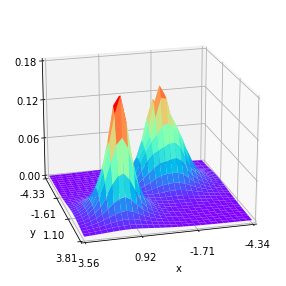

In [11]:
###### 3d prediction surface using WKNN

from NNDE import contour3d
from sklearn.model_selection import GridSearchCV

# generate samples
dim=2
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=contour3d(X_train,method="WKNN",k=100)
model_plot.estimation()
fig=model_plot.make_plot()

fig.savefig("../paper/readme_example_1.pdf",bbox_inches="tight",dpi=600)

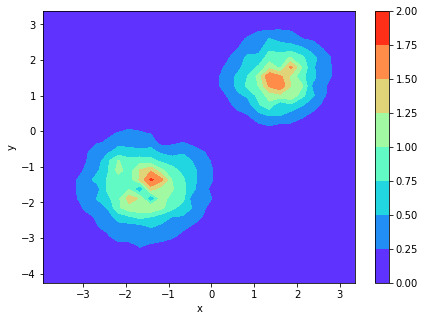

In [12]:
###### 2d prediction surface using BKNN

from NNDE import contour2d
from sklearn.model_selection import GridSearchCV

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=contour2d(X_train,method="BKNN",C=10)
model_plot.estimation()
fig=model_plot.make_plot()

fig.savefig("../paper/readme_example_2.pdf",bbox_inches="tight",dpi=600)


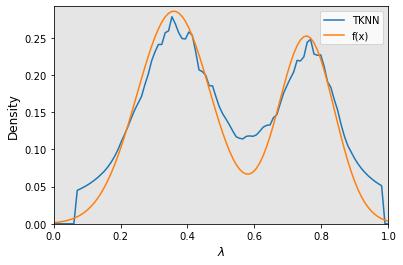

In [13]:
###### 1d prediction line plot using TKNN

from NNDE import lineplot
from sklearn.model_selection import GridSearchCV

# generate samples
dim=1
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)



model_plot=lineplot(X_train,method_seq=["TKNN"],true_density_obj=densitymix,kargs_seq=[{"k":150}])
fig=model_plot.plot()

fig.savefig("../paper/readme_example_3.pdf",bbox_inches="tight",dpi=600)

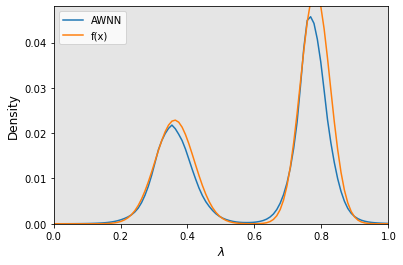

In [14]:
###### high dimensional sliced prediction line plot using AWNN
###### slicing is done


# generate samples
dim=4
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=lineplot(X_train,method_seq=["AWNN"],true_density_obj=densitymix,kargs_seq=[{"C":0.5}])
fig=model_plot.plot()



NameError: name 'aknn' is not defined

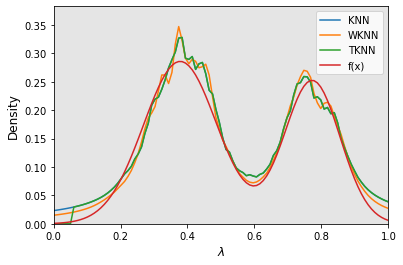

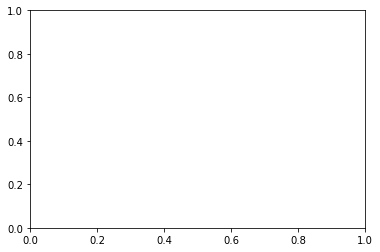

In [15]:
###### plot in the paper 

# generate samples
dim=1
np.random.seed(666)
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)


kargs_seq= [{"k":100},{"k":100},{"k":100} ]
model_plot=lineplot(X_train,method_seq=["KNN", "WKNN", "TKNN"],true_density_obj=densitymix,kargs_seq=kargs_seq)
fig=model_plot.plot()
fig.savefig("../paper/example_1.pdf",bbox_inches="tight",dpi=600)

kargs_seq= [{"C":0.9},{"C":1,"C2":1},{"C":1} ]
model_plot=lineplot(X_train,method_seq=["AKNN", "BKNN", "AWNN"],true_density_obj=densitymix,kargs_seq=kargs_seq)
fig=model_plot.plot()
fig.savefig("../paper/example_2.pdf",bbox_inches="tight",dpi=600)

